In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    return -torch.log(-torch.log(U + eps) + eps)

def gumbel_softmax(logits, temperature=1.0, hard=False):
    g = sample_gumbel(logits.size())
    y = logits + g
    y = y / temperature
    y = F.softmax(y, dim=-1)
    if hard:
        # Straight-through
        max_idx = torch.argmax(y, dim=-1, keepdim=True)
        y_hard = torch.zeros_like(y).scatter_(-1, max_idx, 1.0)
        y = (y_hard - y).detach() + y
    return y

class GumbelBinaryAutoencoder(nn.Module):
    def __init__(self, input_dim=16, hidden_dim=8):
        super().__init__()
        self.hidden_dim = hidden_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, hidden_dim * 2)  # 2 logits per latent dimension
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim * 2, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x, temp=1.0, hard=False):
        logits = self.encoder(x)
        logits = logits.view(-1, self.hidden_dim, 2)
        z = gumbel_softmax(logits, temperature=temp, hard=hard)
        z = z.view(-1, self.hidden_dim * 2)
        # z = logits.view(-1, self.hidden_dim * 2)
        return self.decoder(z)

In [83]:
def testing1():
    input_dim, hidden_dim = 16, 8
    epochs, batch_size, lr = 100, 32, 1e-3
    # temperature schedule
    temp_start = 1.0    # start with a higher temperature (more “soft”)
    temp_end   = 0.05    # end with a lower temperature (more “discrete”)
    temp_decay = (temp_end / temp_start) ** (1.0 / (epochs - 1))

    X = torch.rand(1000, input_dim)
    data_loader = torch.utils.data.DataLoader(X, batch_size=batch_size, shuffle=True)

    model = GumbelBinaryAutoencoder(input_dim, hidden_dim)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    temp = temp_start
    for epoch in range(epochs):
        total_loss = 0
        for batch in data_loader:
            out = model(batch, temp=temp, hard=True)
            loss = criterion(out, batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * len(batch)
        
        avg_loss = total_loss / len(X)
        print(f"Epoch [{epoch+1}/{epochs}], Temp: {temp:.3f}, Loss: {avg_loss:.6f}")
        
        # Anneal temperature
        temp = max(temp_end, temp * temp_decay)

    # Quick test
    with torch.no_grad():
        test_samples = X[:5]
        reconstructed = model(test_samples, temp=1.0, hard=True)
        print("Original:\n", test_samples)
        print("Reconstructed:\n", reconstructed)

    return test_samples, reconstructed


In [84]:
test_samples, reconstructed = testing1()

Epoch [1/100], Temp: 1.000, Loss: 0.083929
Epoch [2/100], Temp: 0.970, Loss: 0.083636
Epoch [3/100], Temp: 0.941, Loss: 0.083345
Epoch [4/100], Temp: 0.913, Loss: 0.082817
Epoch [5/100], Temp: 0.886, Loss: 0.080399
Epoch [6/100], Temp: 0.860, Loss: 0.077514
Epoch [7/100], Temp: 0.834, Loss: 0.075376
Epoch [8/100], Temp: 0.809, Loss: 0.074427
Epoch [9/100], Temp: 0.785, Loss: 0.073245
Epoch [10/100], Temp: 0.762, Loss: 0.072034
Epoch [11/100], Temp: 0.739, Loss: 0.071539
Epoch [12/100], Temp: 0.717, Loss: 0.071214
Epoch [13/100], Temp: 0.696, Loss: 0.071245
Epoch [14/100], Temp: 0.675, Loss: 0.071028
Epoch [15/100], Temp: 0.655, Loss: 0.070775
Epoch [16/100], Temp: 0.635, Loss: 0.070744
Epoch [17/100], Temp: 0.616, Loss: 0.070728
Epoch [18/100], Temp: 0.598, Loss: 0.070567
Epoch [19/100], Temp: 0.580, Loss: 0.070374
Epoch [20/100], Temp: 0.563, Loss: 0.070336
Epoch [21/100], Temp: 0.546, Loss: 0.070362
Epoch [22/100], Temp: 0.530, Loss: 0.070141
Epoch [23/100], Temp: 0.514, Loss: 0.0700

torch.Size([5, 16])


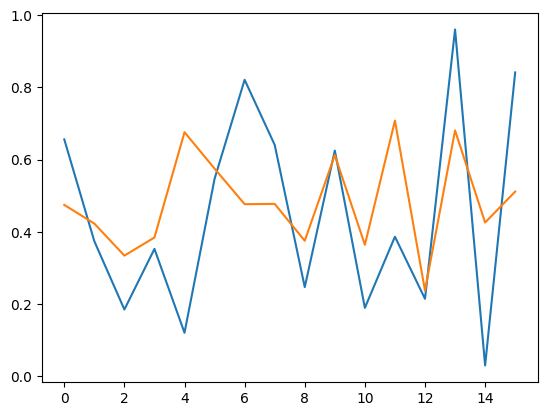

In [85]:
import matplotlib.pyplot as plt
print(test_samples.shape)
plt.plot(test_samples[1])
plt.plot(reconstructed[1])

In [30]:
def testing2():
    input_dim, hidden_dim = 16, 8
    epochs, batch_size, lr = 10, 32, 1e-3
    # temperature schedule
    temp_start = 5.0    # start with a higher temperature (more “soft”)
    temp_end   = 0.5    # end with a lower temperature (more “discrete”)
    temp_decay = (temp_end / temp_start) ** (1.0 / (epochs - 1))

    X = torch.rand(1000, input_dim)
    data_loader = torch.utils.data.DataLoader(X, batch_size=batch_size, shuffle=True)

    model = GumbelBinaryAutoencoder(input_dim, hidden_dim)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    temp = temp_start
    for epoch in range(epochs):
        total_loss = 0
        for batch in data_loader:
            out = model(batch, temp=temp, hard=True)
            print(out.shape)
            loss = criterion(out, batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * len(batch)
        
        avg_loss = total_loss / len(X)
        print(f"Epoch [{epoch+1}/{epochs}], Temp: {temp:.3f}, Loss: {avg_loss:.6f}")
        
        # Anneal temperature
        temp = max(temp_end, temp * temp_decay)

    # Quick test
    with torch.no_grad():
        test_samples = X[:5]
        reconstructed = model(test_samples, temp=1.0, hard=True)
        print("Original:\n", test_samples)
        print("Reconstructed:\n", reconstructed)


In [31]:
testing2()

torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([8, 16])
Epoch [1/10], Temp: 5.000, Loss: 0.083481
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32